# Goal of this notebook: Explore the data
This notebook cleans and explores the Korean bakery sales data referenced in the container repository's README. It is a cursory look at the data and should be considered semi-final for all intents and purposes. I will replicate this analysis and conduct further analysis in a more-formal way in final_notebook.ipynb. If you have questions about this exploration, please contact me directly on Github.

# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# acquire
df = pd.read_csv('Bakery Sales.csv')
df.head(3)

,datetime,day of week,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,...,gateau chocolat,pandoro,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies
0,2019-07-11 15:35,Thur,23800.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,2019-07-11 16:10,Thur,15800.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,2019-07-12 11:49,Fri,58000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Tidy

In [3]:
# drop nulls from important columns
df.dropna(subset=['datetime', 'total'], inplace=True)
# convert datetime column to datetime dtype
df['datetime'] = df.datetime.astype('datetime64')
# set index as datetime
df.index = df.datetime
# drop date-related columns
df.drop(columns='day of week', inplace=True)

In [4]:
# build time-series dataframe
ts = df[['datetime','total']].copy().set_index('datetime')
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2420 entries, 2019-07-11 15:35:00 to 2020-05-02 14:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   total   2420 non-null   float64
dtypes: float64(1)
memory usage: 37.8 KB


# Plot Distribution

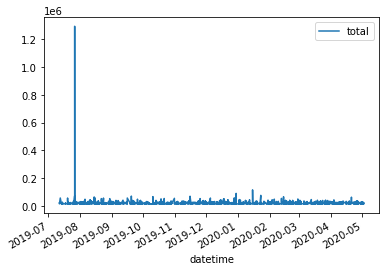

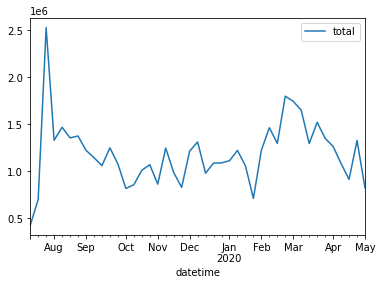

In [5]:
# overall plot
ts.plot()
plt.show()
# plot by week
ts.resample('W').sum().plot()
plt.show()

In [6]:
ts = ts.drop(ts[ts.total == ts.total.max()].index)

# Split
- Explore, Train: 2019
- Validate: Jan, Feb
- Test: Mar, Apr

In [7]:
# create dataframes
explore = df[df.index.year == 2019] # exploratory df
train = ts[ts.index.year == 2019] # time series in-sample
validate = ts[(ts.index.month == 1) | (ts.index.month == 2)] # time series out-of-sample 1
test = ts[(ts.index.month == 3) | (ts.index.month == 4)] # time series out-of-sample 2

explore.shape, train.shape, validate.shape, test.shape

((1331, 26), (1330, 1), (524, 1), (550, 1))

# Explore

<AxesSubplot:xlabel='weekday'>

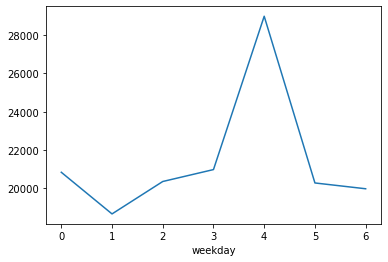

In [8]:
# mean sales by weekday
explore['weekday'] = explore.index.weekday
explore.groupby('weekday').total.mean().round().plot()

<AxesSubplot:xlabel='weekday', ylabel='total'>

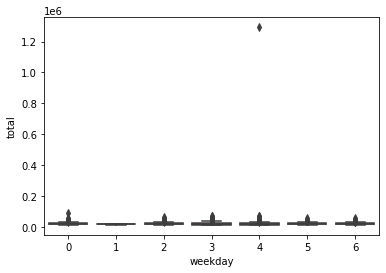

In [9]:
# check for potential outliers
sns.boxplot(explore.weekday, explore.total)

In [10]:
# import an outlier-removal function
def remove_outliers(df, col_list, k=1.5):
    """ 
        Uses Interquartile Rule to remove outliers from dataframe;
        Requires dataframe and list of columns to remove outliers from,
        Accepts an optional k-value (default set to k=1.5),
        Returns full dataframe without outliers in specified columns.
    """
    for col in col_list:
        q1, q3 = df[col].quantile([.25, .75])  # Get quartiles
        iqr = q3 - q1   # Calculate interquartile range
        upper_bound = q3 + k * iqr   # Get upper bound
        lower_bound = q1 - k * iqr   # Get lower bound
        # Create mask
        mask = (df[col] > lower_bound) & (df[col] < upper_bound)
        df = df[mask] # Apply mask
    return df

<AxesSubplot:xlabel='weekday', ylabel='total'>

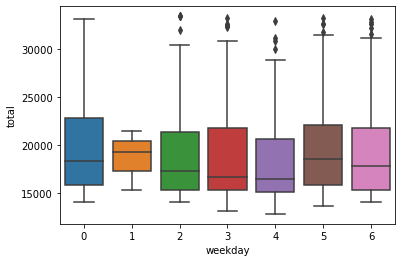

In [11]:
# remove outliers from explore
explore = remove_outliers(explore, ['total'])
sns.boxplot(explore.weekday, explore.total)

In [12]:
# check contents of each product column
# explore.drop(columns=['total','place']) # columns show number of items ordered

In [13]:
# check contents of locality column
explore.place.unique()

array([nan, '효자 3동', '후평 1동', '후평 2동', '석사동', '소양동', '동면', '후평 3동',
       '신사우동', '강남동', '효자 1동', '조운동', '퇴계동', '교동', '약사명동', '효자 2동', '근화동',
       '동내면', '교동 ', '신동면'], dtype=object)

In [14]:
# fix a value
explore[explore.place == '교동 '].place = '교동'

## Coords for places:
- 교동 37.8822, 127.7367 - Chuncheon Central-East; 조운동 37.8785, 127.7314 - Chuncheon Central-West; 후평 1동 37.8891, 127.7458 - Chuncheon Northeast; 후평 2동 37.8768, 127.7487 - Chuncheon Outer-East; 후평 3동 37.8774, 127.7553 - Chuncheon Inner-East; 효자 1동 37.8718, 127.7290 - Chuncheon Southwest, Northwest portion; 효자 2동 37.8688, 127.7377 - Chuncheon Southwest, Middle portion; 효자 3동 37.8762, 127.7415 - Chuncheon Southwest, Northeast portion; 퇴계동 37.8547, 127.7311 - Chuncheon Outer-Southwest; 석사동 37.8596, 127.7474 - Chuncheon Southeast; 소양동 37.8841, 127.7267 - Chuncheon Northwest; 약사명동 37.8755, 127.7251 - Chuncheon West; 신사우동 37.9150, 127.7318 - Chuncheon Far-North; 동면 37.9106, 127.7810 - Chuncheon Far-Northeast / Far-East; 동내면 37.8422, 127.7743 - Chuncheon Far-Southeast; 신동면 37.8144, 127.7028 - Chuncheon Far-Southwest; 강남동 37.8574, 127.7023 - Chuncheon Far-West; 근화동 37.8816, 127.7152 - Chuncheon Far-Northwest

In [15]:
# create new dataframe with locality information
latlong_dict = {'place':['교동', '조운동', '후평 1동', '후평 2동', '후평 3동', '효자 1동', 
                        '효자 2동', '효자 3동', '퇴계동', '석사동', '소양동', '약사명동',
                        '신사우동', '동면', '동내면', '신동면', '강남동', '근화동'],
                'lat':[37.8822, 37.8785, 37.8891, 37.8768, 37.8774, 37.8718, 37.8688, 
                       37.8762, 37.8547, 37.8596, 37.8841, 37.8755, 37.9150, 37.9106, 
                       37.8422, 37.8144, 37.8574, 37.8816],
                'long':[127.7367, 127.7314, 127.7458, 127.7487, 127.7553, 127.7290, 
                        127.7377, 127.7415, 127.7311, 127.7474, 127.7267, 127.7251, 
                        127.7318, 127.7810, 127.7743, 127.7028, 127.7023, 127.7152]
                }
latlong_df = pd.DataFrame(latlong_dict)
latlong_df.head(2)

,place,lat,long
0,교동,37.8822,127.7367
1,조운동,37.8785,127.7314


<AxesSubplot:xlabel='long', ylabel='lat'>

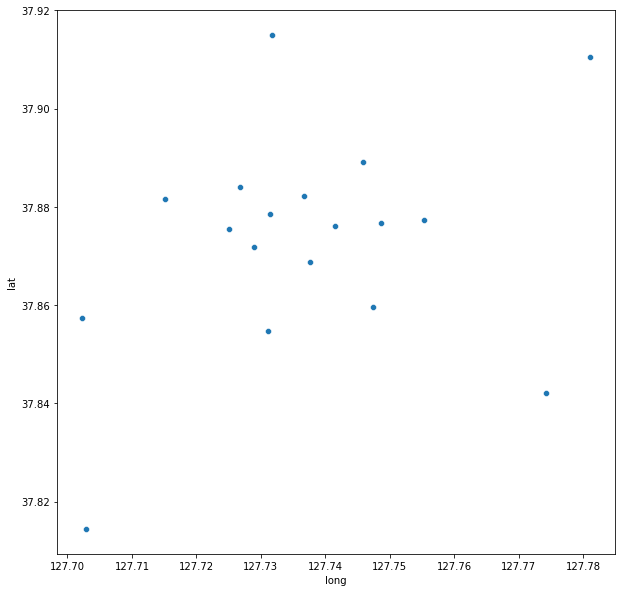

In [16]:
# check work with lat/long plot
plt.figure(figsize=(10,10))
sns.scatterplot(latlong_df.long, latlong_df.lat)

In [17]:
# add boundary information
latlong_df['north'] = latlong_df['lat'] > 37.875
latlong_df['east'] = latlong_df['long'] > 127.735
latlong_df['central'] = ((latlong_df['lat'] > 37.87) &
                         (latlong_df['lat'] < 37.885) &
                         (latlong_df['long'] > 127.72) &
                         (latlong_df['long'] < 127.74))
latlong_df.sort_values(by='lat', ascending=False)

,place,lat,long,north,east,central
12,신사우동,37.9150,127.7318,True,False,False
13,동면,37.9106,127.7810,True,True,False
2,후평 1동,37.8891,127.7458,True,True,False
10,소양동,37.8841,127.7267,True,False,True
0,교동,37.8822,127.7367,True,True,True
17,근화동,37.8816,127.7152,True,False,False
1,조운동,37.8785,127.7314,True,False,True
4,후평 3동,37.8774,127.7553,True,True,False
3,후평 2동,37.8768,127.7487,True,True,False
7,효자 3동,37.8762,127.7415,True,True,False


In [18]:
# merge latlong dataframe back into exploratory dataframe
explore = pd.merge(left=explore, right=latlong_df, on='place')
explore.index = explore.datetime.astype('datetime64') # fix index
explore.drop(columns='datetime', inplace=True) # drop redundant column
explore.head(3)

,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,cacao deep,...,vanila latte,berry ade,tiramisu,merinque cookies,weekday,lat,long,north,east,central
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-12 12:39:00,24300.0,효자 3동,1.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,37.8762,127.7415,True,True,False
2019-08-12 12:41:00,15800.0,효자 3동,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,37.8762,127.7415,True,True,False
2019-08-14 11:04:00,18300.0,효자 3동,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,37.8762,127.7415,True,True,False


<AxesSubplot:xlabel='place', ylabel='total'>

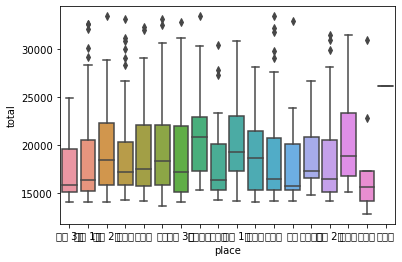

In [19]:
# visual check for if localities have differences
sns.boxplot(explore.place, explore.total)

<AxesSubplot:xlabel='central', ylabel='total'>

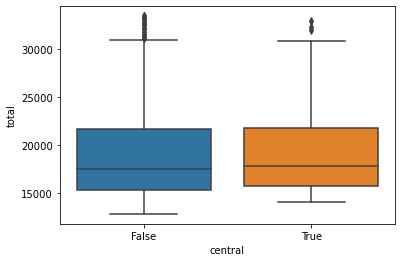

In [20]:
# visual check of central against not-central localities
sns.boxplot(explore.central, explore.total)

<AxesSubplot:xlabel='north', ylabel='total'>

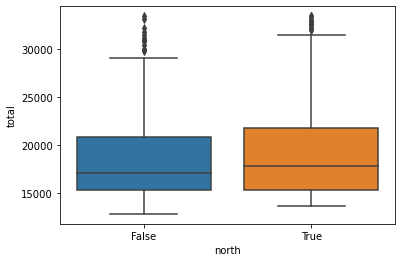

In [21]:
# visual check of north v south
sns.boxplot(explore.north, explore.total)

<AxesSubplot:xlabel='east', ylabel='total'>

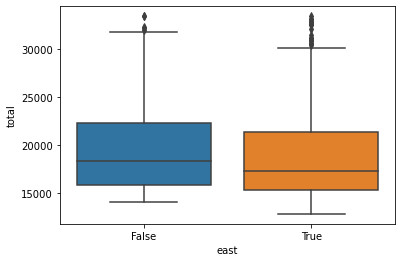

In [22]:
# visual check of east v west
sns.boxplot(explore.east, explore.total)

In [23]:
# create new north & west column to maximize difference
explore['northwest'] = (explore.north == True) & (explore.east == False)
explore.northwest.unique()

array([False,  True])

<AxesSubplot:xlabel='northwest', ylabel='total'>

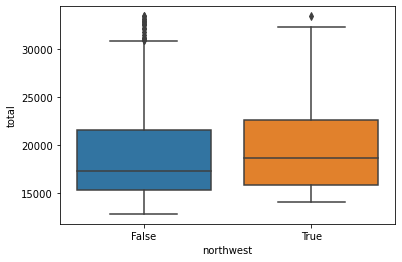

In [24]:
# check northwest against all others
sns.boxplot(explore.northwest, explore.total)

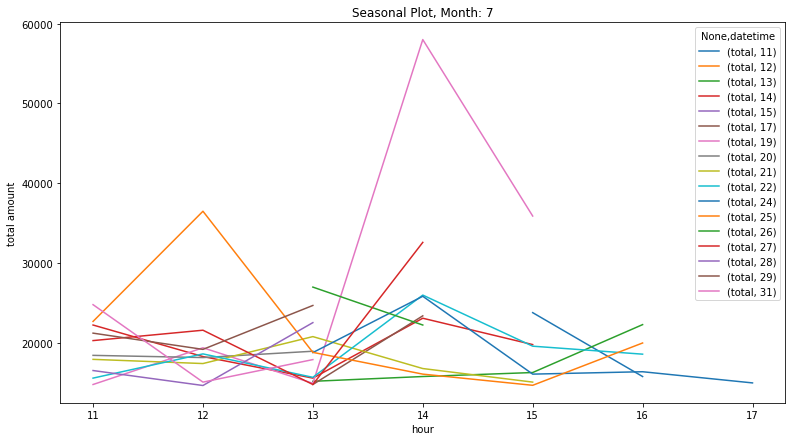

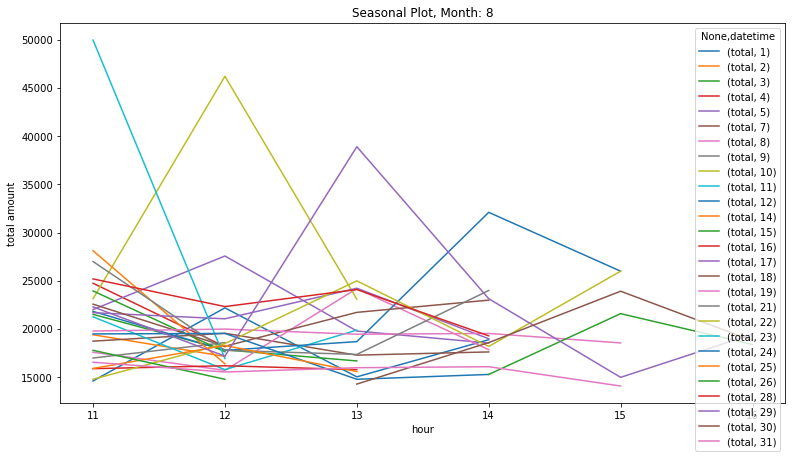

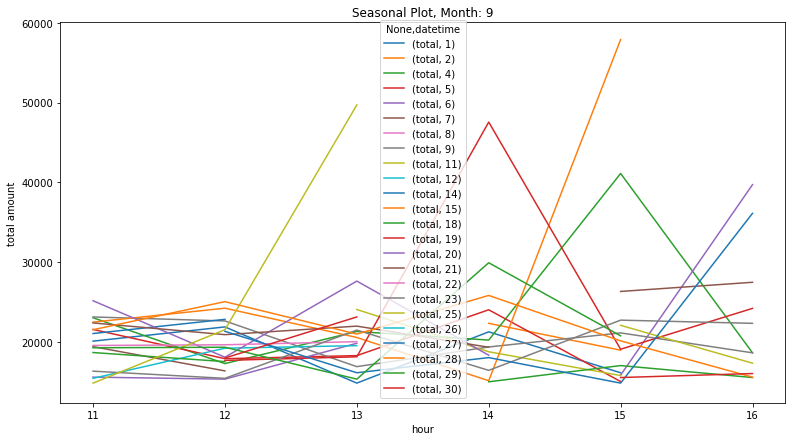

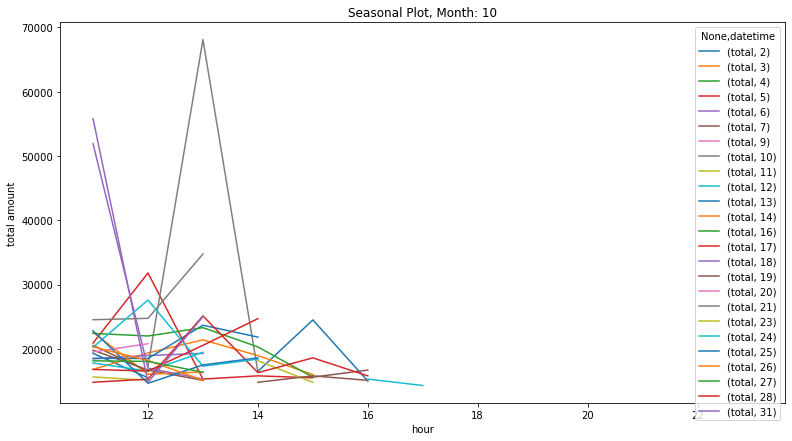

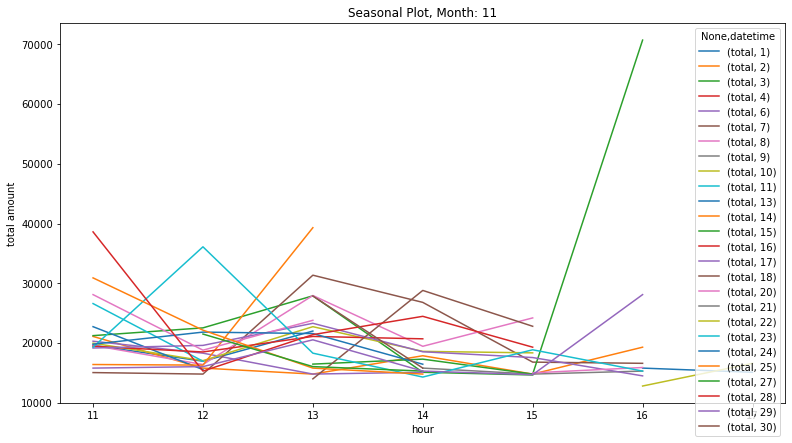

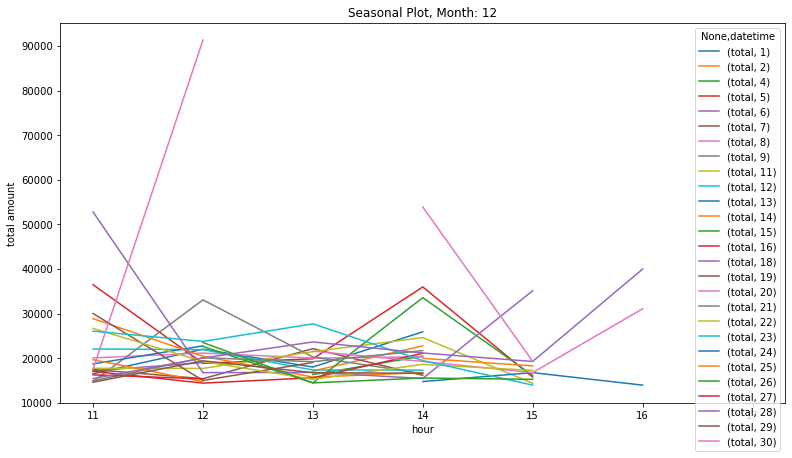

In [25]:
# seasonal diff plot by hour, using each day, plotting each month
months = [7,8,9,10,11,12]
for month in months:
    mask = train.index.month == month
    train[mask].groupby([train[mask].index.day, train[mask].index.hour]).mean().unstack(0)\
    .plot(title='Seasonal Plot, Month: ' + str(month), figsize=(13,7))
    plt.xlabel('hour')
    plt.ylabel('total amount')
    plt.show()

# Exploration Takeaways
## Time-Based Findings
- Because this data spans less than a year, we can't establish year-over-year changes
- Even though we can't establigh year-over-year changes, we can and should look at whether revenue is growing over time
- At the monthly level...
    * Some months have higher totals than others, and we should conduct some statistical testing to see if the differences are statistically significant
    * Revenue does not seem to be cyclical from a visual look
- At the weekly level...
    * Some weeks have higher totals than others, but this is essentially redundant to monthly changes
    * Revenue does not seem to be cyclical from a visual look
- At the daily level...
    * Some weekdays seem to have higher revenue than others from initial plots, and we should make sure that's the case with statistical testing
    * Revenue might be cyclical on a week-to-week basis, and we should investigate this further
- At the hourly level...
    * Revenue seems to be consistent throughout the day, with some expected fluctuations from large orders, and the hourly-mean is likely to become the best prediction for the modeling phase

## Locality Findings
- This bakery serves the city of Chuncheon in South Korea.
- Some localities within the city source more revenue than others, and we should look at whether these differences are statistically significant
- Some overall regions of the city that this bakery serves source more revenue than others, specifically in the northwest portion of the city, and we should look at whether the difference is statistically significant

## Other Findings
- Item columns show how many of each item were sold in the transaction
    * We should look at item sales to see which items are selling most, which are selling least, and which are driving the most revenue and least revenue

In [26]:
# df.to_csv('bake_sales.csv')
# explore.to_csv('explore.csv')
# train.to_csv('train.csv')
# validate.to_csv('validate.csv')
# test.to_csv('test.csv')